In [67]:
#!pip install yfinance

import pandas as pd
from pandas.plotting import autocorrelation_plot
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from yfinance import download
from datetime import datetime
from pandas.plotting import lag_plot
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.api import OLS, add_constant
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
import datetime as dt
import os

In [68]:
# Define the date range for fetching data
start_date = '2024-01-01'
end_date = '2024-12-31'

# Fetch data using yfinance
def fetch_stock_data(ticker):
    return download(ticker, start=start_date, end=end_date)

# Get FAANG data
fb = fetch_stock_data('META')
aapl = fetch_stock_data('AAPL')
amzn = fetch_stock_data('AMZN')
nflx = fetch_stock_data('NFLX')
goog = fetch_stock_data('GOOG')

# Get S&P 500 data
sp = fetch_stock_data('^GSPC')

# Get bitcoin data in USD
bitcoin = fetch_stock_data('BTC-USD')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [69]:
# Define a function to clean the datasets
def clean_dataset(filepath, column_names):
    """
    Cleans a dataset by:
    - Removing the first two rows (assumed to be metadata).
    - Renaming columns to a standardized format.
    - Converting numeric columns to proper data types.
    """
    # Load the dataset
    df = pd.read_csv(filepath)

    # Remove metadata rows and reset index
    df = df[2:].reset_index(drop=True)

    # Assign proper column names
    df.columns = column_names

    # Convert 'Date' column to datetime
    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'])

    # Convert numeric columns to appropriate types
    numeric_columns = [col for col in column_names if col != 'Date']
    df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')

    return df

# Define the directory for datasets and filepaths
dataset_dir = r"C:\\Users\\alanm\\OneDrive\\Documents\\Hands-On-Data-Analysis-with-Pandas-2nd-edition\\Hands-On-Data-Analysis-with-Pandas-2nd-edition-1\\ch_07"

# Filepaths and column names for each dataset
datasets_info = {
    "^GSPC": (f"{dataset_dir}\\^GSPC_data.csv", ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']),
    "AAPL": (f"{dataset_dir}\\AAPL_data.csv", ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']),
    "AMZN": (f"{dataset_dir}\\AMZN_data.csv", ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']),
    "BTC-USD": (f"{dataset_dir}\\BTC-USD_data.csv", ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']),
    "GOOG": (f"{dataset_dir}\\GOOG_data.csv", ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']),
    "META": (f"{dataset_dir}\\META_data.csv", ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']),
    "NFLX": (f"{dataset_dir}\\NFLX_data.csv", ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']),
}

# Clean all datasets
cleaned_data = {name: clean_dataset(filepath, columns) for name, (filepath, columns) in datasets_info.items()}

In [70]:
# Data inspection (example for Apple stock)
print(aapl.head())


Price            Close        High         Low        Open    Volume
Ticker            AAPL        AAPL        AAPL        AAPL      AAPL
Date                                                                
2024-01-02  184.734985  187.521338  182.993517  186.237618  82488700
2024-01-03  183.351761  184.973819  182.535751  183.321908  58414500
2024-01-04  181.023163  182.197403  179.998185  181.261983  71983600
2024-01-05  180.296722  181.869022  179.291652  181.102786  62303300
2024-01-08  184.655365  184.695178  180.615161  181.202281  59144500


In [71]:
# Basic statistics
print(aapl.describe())

Price        Close        High         Low        Open        Volume
Ticker        AAPL        AAPL        AAPL        AAPL          AAPL
count   251.000000  251.000000  251.000000  251.000000  2.510000e+02
mean    206.596169  208.292135  204.606815  206.333798  5.719756e+07
std      25.617883   25.689310   25.236735   25.429415  3.087430e+07
min     164.405121  165.800067  163.488440  164.753864  2.323470e+07
25%     183.418915  184.522844  181.646251  182.955803  4.187125e+07
50%     213.757141  216.291416  211.442359  213.447818  4.994790e+07
75%     227.088608  228.990456  225.061156  227.130076  6.295815e+07
max     259.019989  260.100006  257.630005  258.190002  3.186799e+08


In [72]:
#Define portfolio class
# Group FAANG stocks
def group_stocks(stock_dict):
    return pd.concat({key: stock["Close"] for key, stock in stock_dict.items()}, axis=1)

# Data groups
faang = group_stocks(
    {
        'Facebook': fb, 
        'Apple': aapl, 
        'Amazon': amzn, 
        'Netflix': nflx, 
        'Google': goog
    }
)

faang_sp = group_stocks(
    {
        'Facebook': fb, 
        'Apple': aapl, 
        'Amazon': amzn, 
        'Netflix': nflx, 
        'Google': goog,
        'S&P 500': sp
    }
)

all_assets = group_stocks(
    {
        'Bitcoin': bitcoin,
        'S&P 500': sp,
        'Facebook': fb, 
        'Apple': aapl, 
        'Amazon': amzn, 
        'Netflix': nflx, 
        'Google': goog
    }
)

In [73]:
# Example function for support and resistance visualization
def support_and_resistance(data, title='Support and Resistance Example'):
    plt.figure(figsize=(15, 7))
    plt.plot(data['Date'], data['Close'], label='Close Prices', color='blue')
    plt.axhline(y=data['Close'].max(), color='red', linestyle='--', label='Resistance Level')
    plt.axhline(y=data['Close'].min(), color='green', linestyle='--', label='Support Level')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

# Example function for time series decomposition
def time_series_decomposition(ts, period=12):
    decomposition = seasonal_decompose(ts, model='additive', period=period)
    fig = decomposition.plot()
    fig.set_size_inches(15, 8)
    plt.show()

In [74]:
# Define the dataset directory
dataset_dir = r"C:\\Users\\alanm\\OneDrive\\Documents\\Hands-On-Data-Analysis-with-Pandas-2nd-edition\\Hands-On-Data-Analysis-with-Pandas-2nd-edition-1\\ch_07"

# Define file names for all datasets
file_names = {
    "Amazon": "AMZN_data.csv",
    "Apple": "AAPL_data.csv",
    "Bitcoin": "BTC-USD_data.csv",
    "Facebook": "META_data.csv",
    "Google": "GOOG_data.csv",
    "Netflix": "NFLX_data.csv",
    "S&P 500": "^GSPC_data.csv"
}

# Define a function to process each dataset and compute summary statistics
def process_data(file_path):
    # Read data
    df = pd.read_csv(file_path)
    # Ensure the necessary columns exist and clean data
    df = df.rename(columns=lambda x: x.strip())
    if 'Close' in df.columns:
        df['Close'] = pd.to_numeric(df['Close'], errors='coerce')  # Ensure 'Close' is numeric
        return df['Close'].describe()  # Compute summary statistics for the 'Close' column

# Read and process all datasets into a group_stocks structure
all_assets = {
    name: process_data(os.path.join(dataset_dir, file_name))
    for name, file_name in file_names.items()
}

# Convert to DataFrame and structure rows and columns as specified
summary_df = pd.DataFrame(all_assets).T
summary_df.rename(
    columns={
        "count": "Count",
        "mean": "Mean",
        "std": "Std",
        "min": "Min",
        "25%": "25%",
        "50%": "50%",
        "75%": "75%",
        "max": "Max"
    },
    inplace=True
)

# Ensure the rows are named properly
summary_df.index.name = "Stock"

# Display the final summary DataFrame
from IPython.display import display
display(summary_df)



,Count,Mean,Std,Min,25%,50%,75%,Max
Stock,,,,,,,,
Amazon,251.0,184.490199,17.322854,144.570007,175.370003,183.320007,189.599998,232.929993
Apple,251.0,206.596169,25.617883,164.405121,183.418907,213.757141,227.088608,259.019989
Bitcoin,365.0,65888.868290,14632.134647,39507.367188,59027.625000,64118.792969,69122.335938,106140.601562
Facebook,251.0,507.971077,62.408399,343.159149,474.502274,503.792603,562.756073,632.170044
Google,251.0,164.779143,15.502511,132.085388,152.795998,165.972992,176.108116,198.160004
Netflix,251.0,670.624462,109.578031,468.500000,608.980011,647.659973,706.854980,936.559998
S&P 500,251.0,5426.428765,367.685189,4688.680176,5134.015137,5434.430176,5716.104980,6090.270020


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Flattened Columns in AAPL DataFrame:
Index(['AAPL_('Close', 'AAPL')', 'AAPL_('High', 'AAPL')',
       'AAPL_('Low', 'AAPL')', 'AAPL_('Open', 'AAPL')',
       'AAPL_('Volume', 'AAPL')'],
      dtype='object')


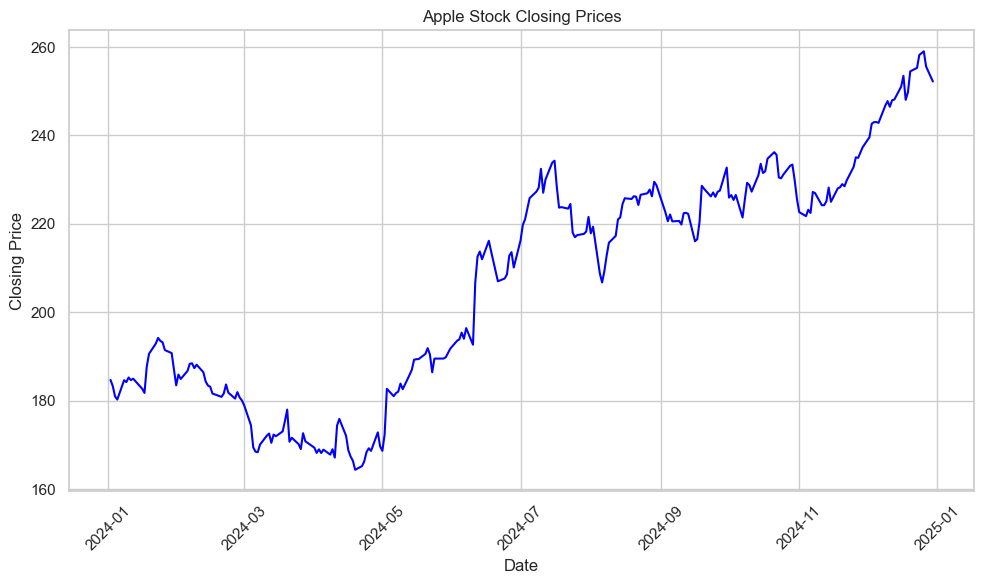

In [75]:
# Fetch data using yfinance
def fetch_stock_data(ticker):
    data = download(ticker, start=start_date, end=end_date)
    data.columns = [f"{ticker}_{col}" for col in data.columns]  # Prefix columns with ticker symbol
    return data

# Fetch data again to ensure column names are updated
fb = fetch_stock_data('META')
aapl = fetch_stock_data('AAPL')
amzn = fetch_stock_data('AMZN')
nflx = fetch_stock_data('NFLX')
goog = fetch_stock_data('GOOG')
sp = fetch_stock_data('^GSPC')
bitcoin = fetch_stock_data('BTC-USD')

# Debug: Check the updated column names
print("Flattened Columns in AAPL DataFrame:")
print(aapl.columns)

# Check for the closing price column
closing_column = None
for col in aapl.columns:
    if 'Close' in col:
        closing_column = col
        break

if closing_column is None:
    raise KeyError("Column for closing prices not found. Available columns: " + ', '.join(aapl.columns))

# Example plot: Apple stock closing prices
plt.figure(figsize=(10, 6))
sns.lineplot(x=aapl.index, y=aapl[closing_column], color="blue")
plt.title("Apple Stock Closing Prices")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


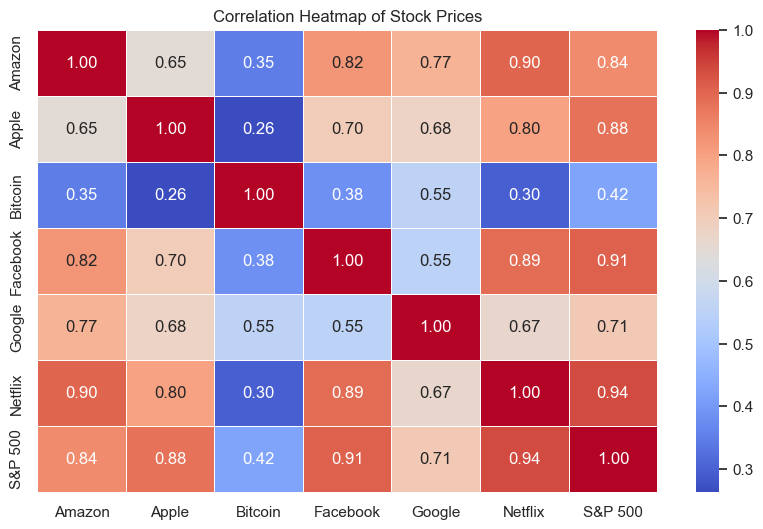

In [76]:
# Define file names for all datasets
file_names = {
    "Amazon": "AMZN_data.csv",
    "Apple": "AAPL_data.csv",
    "Bitcoin": "BTC-USD_data.csv",
    "Facebook": "META_data.csv",
    "Google": "GOOG_data.csv",
    "Netflix": "NFLX_data.csv",
    "S&P 500": "^GSPC_data.csv"
}

# Load datasets and extract 'Close' prices
data = {}
for name, file_name in file_names.items():
    file_path = os.path.join(dataset_dir, file_name)
    df = pd.read_csv(file_path)
    df = df.rename(columns=lambda x: x.strip())
    if 'Close' in df.columns:
        df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
        data[name] = df['Close']

# Create a DataFrame with all assets' 'Close' prices
close_prices = pd.DataFrame(data)

# Compute the correlation matrix
correlation_matrix = close_prices.corr()

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Stock Prices")
plt.show()

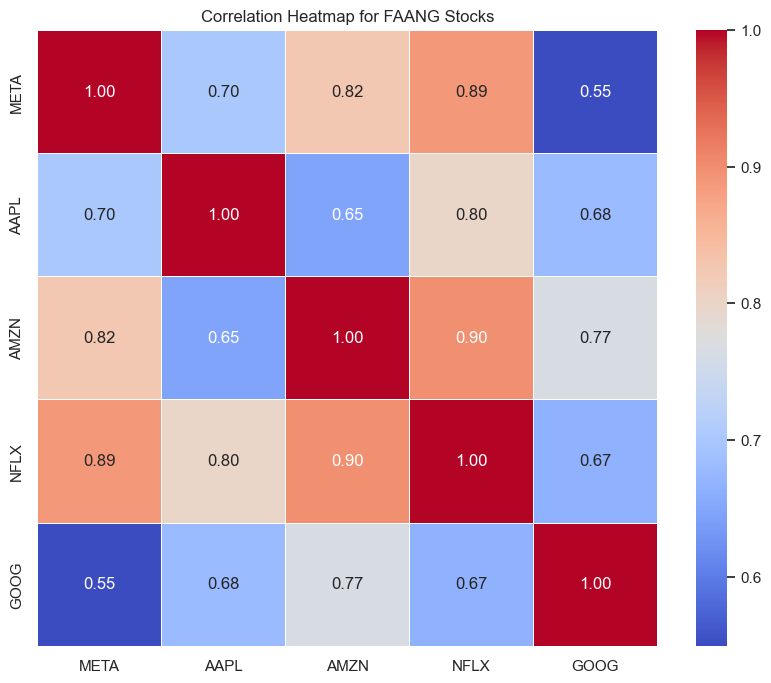

In [77]:
# Example correlation heatmap for FAANG stocks
faang.columns = ['META', 'AAPL', 'AMZN', 'NFLX', 'GOOG']  # Ensure correct column names
correlation_matrix = faang.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap for FAANG Stocks")
plt.show()

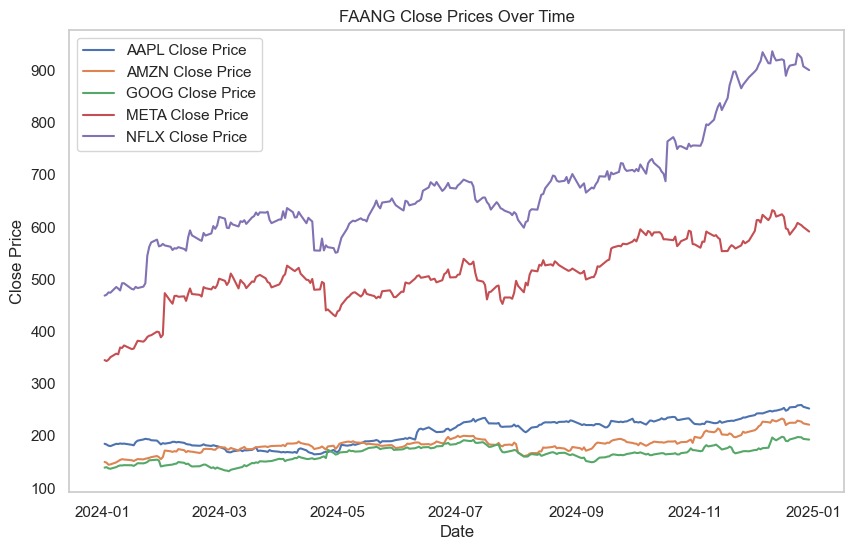

In [78]:
# Line plot for FAANG stock prices (Close)
plt.figure(figsize=(10, 6))
for name in ['AAPL', 'AMZN', 'GOOG', 'META', 'NFLX']:
    plt.plot(cleaned_data[name]['Date'], cleaned_data[name]['Close'], label=f'{name} Close Price')
plt.title('FAANG Close Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid()
plt.show()


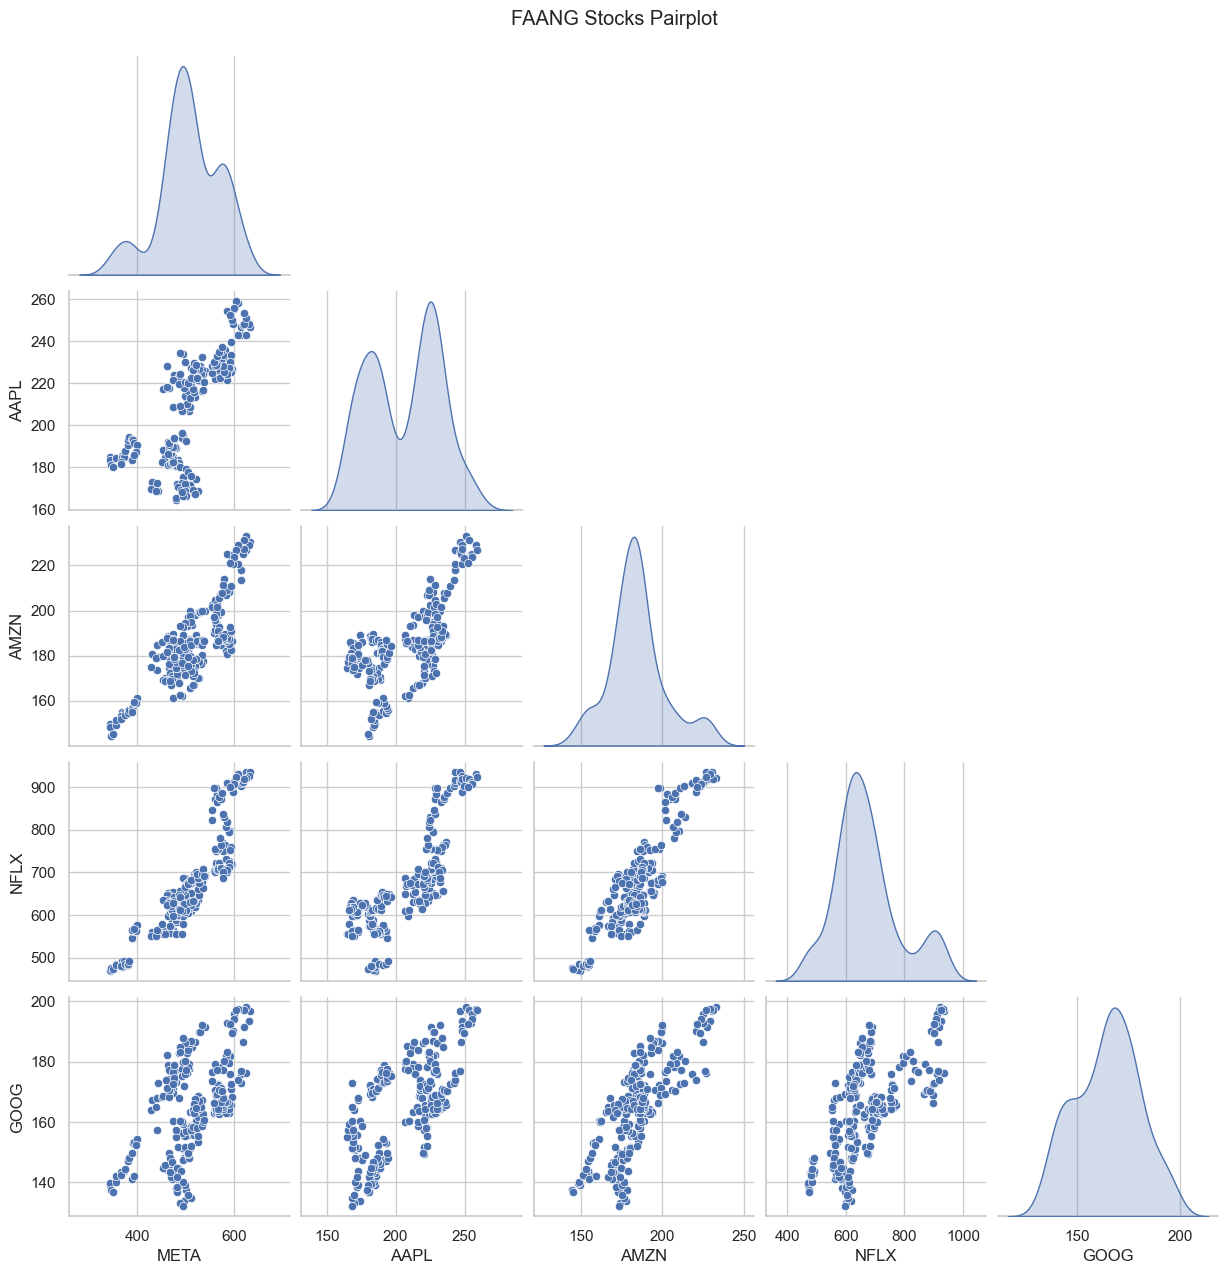

In [102]:
# Example pairplot for FAANG stocks
sns.set_theme(style="whitegrid")
faang_viz = faang.reset_index(drop=True)  # Reset index for visualization
sns.pairplot(faang_viz, diag_kind="kde", kind="scatter", corner=True)
plt.suptitle("FAANG Stocks Pairplot", y=1.02)
plt.show()

In [81]:
print("Columns in Netflix DataFrame:", nflx.columns)


Columns in Netflix DataFrame: Index(['NFLX_('Close', 'NFLX')', 'NFLX_('High', 'NFLX')',
       'NFLX_('Low', 'NFLX')', 'NFLX_('Open', 'NFLX')',
       'NFLX_('Volume', 'NFLX')'],
      dtype='object')


In [82]:
# Ensure column names are correct
def fetch_stock_data(ticker):
    data = download(ticker, start=start_date, end=end_date)
    if 'Close' not in data.columns:
        raise KeyError(f"'Close' column is missing in the data for {ticker}. Available columns: {list(data.columns)}")
    return data

# Fetch Netflix data again for verification
nflx = fetch_stock_data('NFLX')
print("Columns in Netflix DataFrame:", nflx.columns)

# Custom Stock Analyzer Class
class StockAnalyzer:
    def __init__(self, data):
        self.data = data

    def annualized_volatility(self):
        if 'Close' not in self.data.columns:
            raise KeyError("'Close' column is missing in the DataFrame.")
        daily_returns = self.data['Close'].pct_change()
        return daily_returns.std() * np.sqrt(252)  # 252 trading days in a year

# Perform stock analysis on Netflix
nflx_analyzer = StockAnalyzer(nflx)
try:
    print("Netflix Annualized Volatility:", nflx_analyzer.annualized_volatility())
except KeyError as e:
    print(e)


[*********************100%***********************]  1 of 1 completed

Columns in Netflix DataFrame: MultiIndex([( 'Close', 'NFLX'),
            (  'High', 'NFLX'),
            (   'Low', 'NFLX'),
            (  'Open', 'NFLX'),
            ('Volume', 'NFLX')],
           names=['Price', 'Ticker'])
Netflix Annualized Volatility: Ticker
NFLX    0.295393
dtype: float64


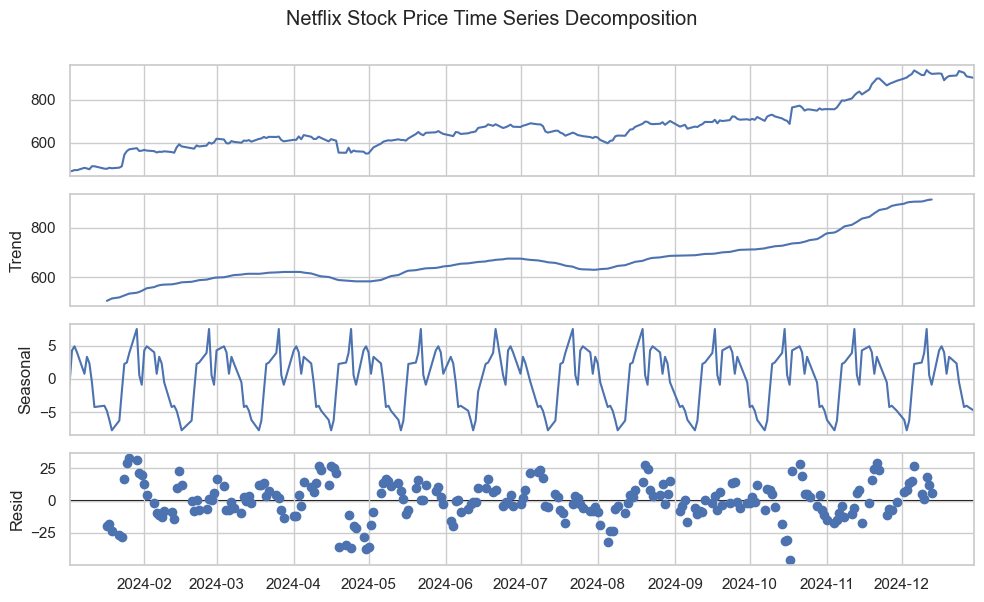

In [101]:
class StockModeler:
	@staticmethod
	def decompose(data, period):
		return sm.tsa.seasonal_decompose(data['Close'], period=period)

# Perform decomposition
decomposition = StockModeler.decompose(nflx, 20) # 20 period frequency
fig = decomposition.plot()
fig.suptitle('Netflix Stock Price Time Series Decomposition', y=1)
fig.set_figheight(6)
fig.set_figwidth(10)
fig.tight_layout()

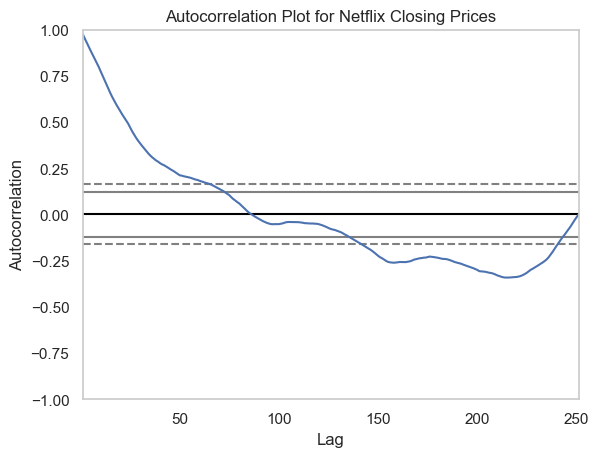

In [15]:
# Use the 'Close' column for the autocorrelation plot
from pandas.plotting import autocorrelation_plot

if 'Close' in nflx.columns:
    autocorrelation_plot(nflx['Close'])
    plt.title("Autocorrelation Plot for Netflix Closing Prices")
    plt.show()
else:
    print("The 'Close' column is not available in the Netflix DataFrame.")


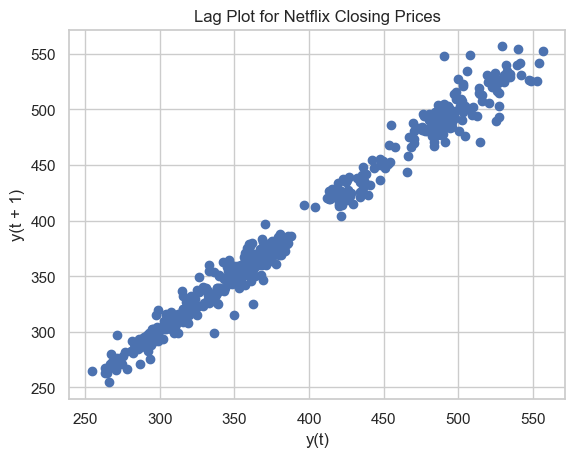

In [25]:
# Lag plot for Netflix stock
data_to_plot = nflx['Close'] if 'Close' in nflx.columns else None
if data_to_plot is not None:
    lag_plot(data_to_plot)
    plt.title("Lag Plot for Netflix Closing Prices")
    plt.show()
else:
    print("The 'Close' column is not available for Netflix data.")

c:\Users\alanm\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\alanm\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\alanm\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\alanm\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary startin

                               SARIMAX Results                                
Dep. Variable:                   NFLX   No. Observations:                  250
Model:                ARIMA(10, 1, 5)   Log Likelihood                -888.904
Date:                Wed, 08 Jan 2025   AIC                           1809.809
Time:                        16:32:52   BIC                           1866.088
Sample:                             0   HQIC                          1832.462
                                - 250                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5761      6.026      0.096      0.924     -11.234      12.386
ar.L2          0.2942      1.752      0.168      0.867      -3.140       3.728
ar.L3          0.1113      0.516      0.216      0.8

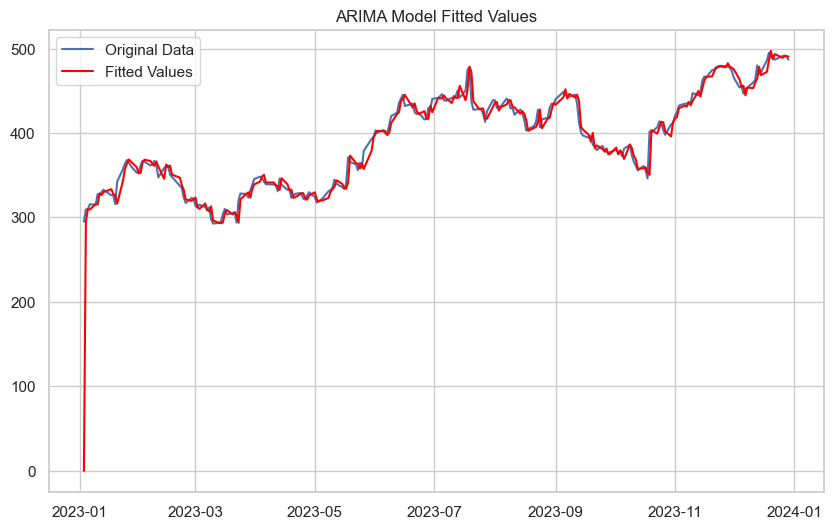

In [41]:
# Prepare the Netflix data for ARIMA modeling
if 'Close' in nflx.columns:
    nflx_close = nflx['Close'].dropna()  # Ensure no missing values
else:
    raise KeyError("The 'Close' column is not available in the Netflix data.")

# Define ARIMA parameters
ar_order = 10  # Autoregressive term
i_order = 1    # Differencing term
ma_order = 5   # Moving average term

# Fit the ARIMA model
arima_model = ARIMA(nflx_close, order=(ar_order, i_order, ma_order))
arima_result = arima_model.fit()

# Display the ARIMA model summary
print(arima_result.summary())

# Plot the fitted values
plt.figure(figsize=(10, 6))
plt.plot(nflx_close, label="Original Data")
plt.plot(arima_result.fittedvalues, label="Fitted Values", color="red")
plt.title("ARIMA Model Fitted Values")
plt.legend()
plt.show()


In [62]:
# Perform linear regression analysis for Netflix
if 'Close' in nflx.columns and 'Volume' in nflx.columns:
    X = sm.add_constant(nflx['Volume'])  # Independent variable (add constant for intercept)
    Y = nflx['Close']  # Dependent variable
    lm = OLS(Y, X).fit()
    print(lm.summary())
else:
    print("Regression analysis requires both 'Close' and 'Volume' columns in the Netflix data.")


                            OLS Regression Results                            
Dep. Variable:                   NFLX   R-squared:                       0.054
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     14.31
Date:                Fri, 10 Jan 2025   Prob (F-statistic):           0.000194
Time:                        17:06:13   Log-Likelihood:                -1527.5
No. Observations:                 251   AIC:                             3059.
Df Residuals:                     249   BIC:                             3066.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        707.6509     11.883     59.552      0.0

c:\Users\alanm\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\alanm\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\alanm\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


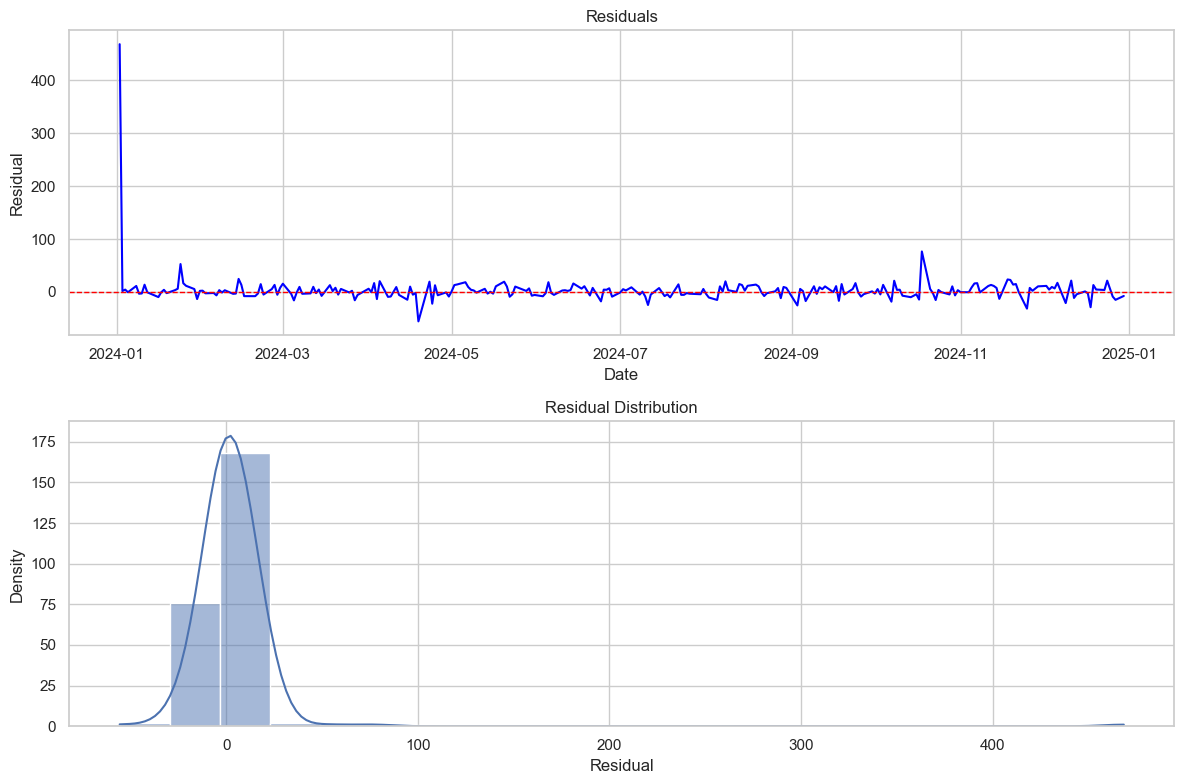

In [ ]:
def fit_arima_model(data, order):
    """
    Fits an ARIMA model to the given data.
    
    Parameters:
    data (Series): Time series data to fit the model.
    order (tuple): The (p, d, q) order of the ARIMA model.
    
    Returns:
    ARIMAResults: The fitted ARIMA model results.
    """
    model = ARIMA(data, order=order)
    return model.fit()

def plot_residuals(residuals):
    """
    Plots the residuals and residual distribution from a time series model.
    
    Parameters:
    residuals (Series): Residuals from the time series model.
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    
    ax1.plot(residuals, color='blue')
    ax1.axhline(y=0, color='red', linestyle='--', linewidth=1)
    ax1.set_title('Residuals')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Residual')
    
    sns.histplot(residuals, kde=True, bins=20, ax=ax2)
    ax2.set_title('Residual Distribution')
    ax2.set_xlabel('Residual')
    ax2.set_ylabel('Density')
    
    plt.tight_layout()
    plt.show()

# Define ARIMA order
arima_order = (5, 1, 0)  # (p, d, q) order

# Fit ARIMA model and plot residuals
arima_results = fit_arima_model(nflx['Close'], order=arima_order)
plot_residuals(arima_results.resid)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
C:\Users\alanm\AppData\Local\Temp\ipykernel_16616\3979315811.py:60: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  return data.pct_change().fillna(0)
C:\Users\alanm\AppData\Local\Temp\ipykernel_16616\3979315811.py:74: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset 

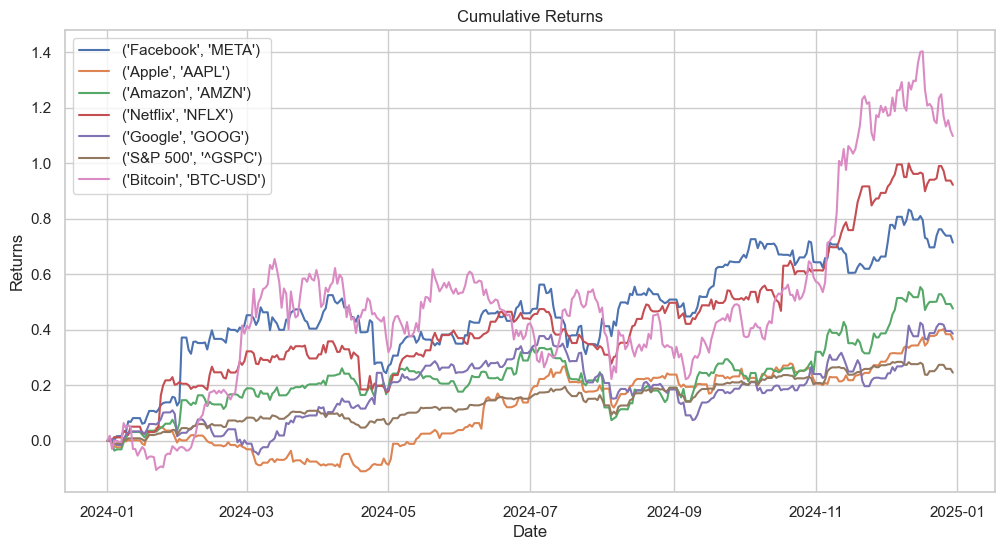

C:\Users\alanm\AppData\Local\Temp\ipykernel_16616\3979315811.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data[f'{window}D_MA'] = stock_data.rolling(window=window).mean()


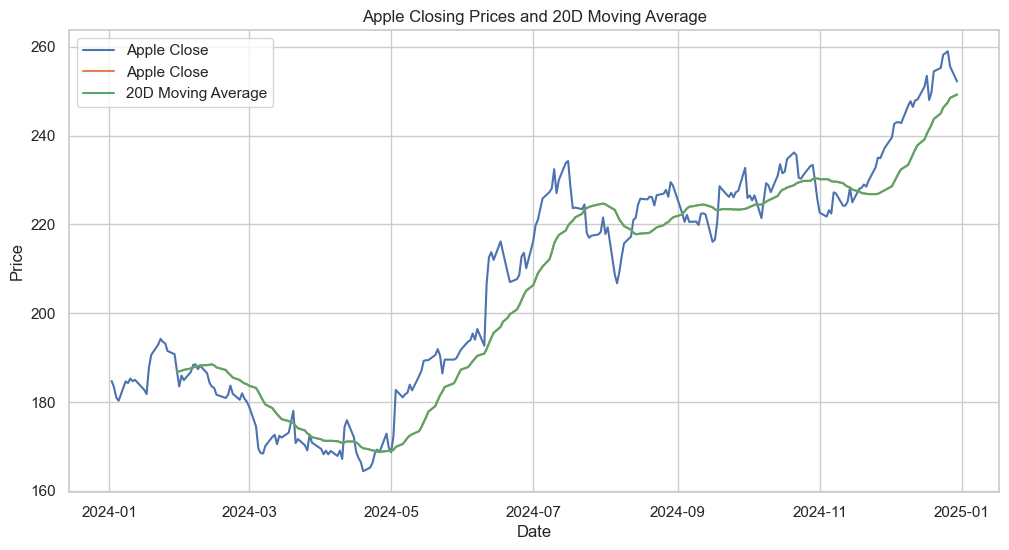

In [92]:
# Define the date range for fetching data
start_date = '2024-01-01'
end_date = '2024-12-31'

# Fetch data using yfinance
def fetch_stock_data(ticker):
    """
    Fetches historical stock data for a given ticker symbol using yfinance.
    Returns a DataFrame with the fetched data.
    """
    return download(ticker, start=start_date, end=end_date)

# Get FAANG and market data
fb_data = fetch_stock_data('META') 
aapl_data = fetch_stock_data('AAPL')
amzn_data = fetch_stock_data('AMZN') 
nflx_data = fetch_stock_data('NFLX')
goog_data = fetch_stock_data('GOOG')
sp500_data = fetch_stock_data('^GSPC') 
bitcoin_data = fetch_stock_data('BTC-USD')

# Group stocks into DataFrames
def group_stocks(stock_dict):
    """
    Groups stock data from a dictionary into a single DataFrame.
    The resulting DataFrame has stock tickers as column names and closing prices as values.
    """
    return pd.concat({key: stock['Close'] for key, stock in stock_dict.items()}, axis=1)

faang_data = group_stocks({
    'Facebook': fb_data,
    'Apple': aapl_data, 
    'Amazon': amzn_data,
    'Netflix': nflx_data,
    'Google': goog_data
})

faang_sp500_data = group_stocks({
    'Facebook': fb_data,
    'Apple': aapl_data,
    'Amazon': amzn_data,
    'Netflix': nflx_data,
    'Google': goog_data,
    'S&P 500': sp500_data
})

all_assets_data = group_stocks({
    'Facebook': fb_data,
    'Apple': aapl_data,
    'Amazon': amzn_data,
    'Netflix': nflx_data,
    'Google': goog_data, 
    'S&P 500': sp500_data,
    'Bitcoin': bitcoin_data
})

# Functions for calculating returns
def calculate_returns(data):
    """Calculates daily returns."""
    return data.pct_change().fillna(0)

def calculate_cumulative_returns(data):
    """Calculates cumulative returns."""
    returns = calculate_returns(data)
    return (1 + returns).cumprod() - 1

# Plotting
def plot_cumulative_returns(data):
    """Plots cumulative returns for the given data."""
    cumulative_returns = calculate_cumulative_returns(data)
    
    plt.figure(figsize=(12, 6))
    for col in cumulative_returns.columns:
        plt.plot(cumulative_returns[col], label=col)
    
    plt.title("Cumulative Returns")
    plt.xlabel("Date") 
    plt.ylabel("Returns")
    plt.legend()
    plt.show()

def plot_moving_averages(data, ticker, window=20):
    """Plots closing prices and moving average for a given stock ticker."""
    stock_data = data[ticker]
    stock_data[f'{window}D_MA'] = stock_data.rolling(window=window).mean()
    
    plt.figure(figsize=(12, 6))
    plt.plot(stock_data, label=f'{ticker} Close')
    plt.plot(stock_data[f'{window}D_MA'], label=f'{window}D Moving Average')
    plt.title(f"{ticker} Closing Prices and {window}D Moving Average")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

# Example usage
plot_cumulative_returns(all_assets_data)
plot_moving_averages(faang_data, 'Apple')


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
C:\Users\alanm\AppData\Local\Temp\ipykernel_16616\1568513543.py:60: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  return data.pct_change().fillna(0)
C:\Users\alanm\AppData\Local\Temp\ipykernel_16616\1568513543.py:74: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset 

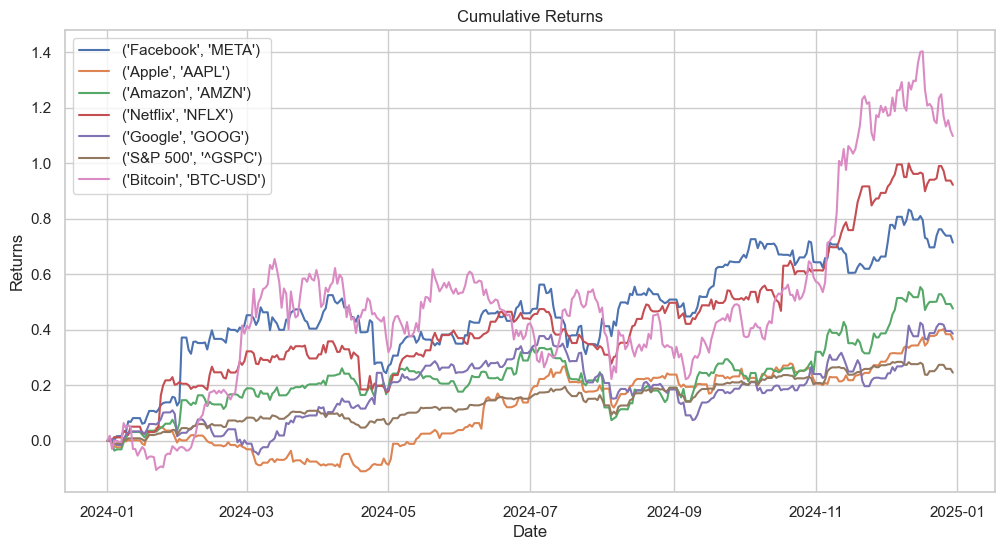

C:\Users\alanm\AppData\Local\Temp\ipykernel_16616\1568513543.py:60: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  return data.pct_change().fillna(0)


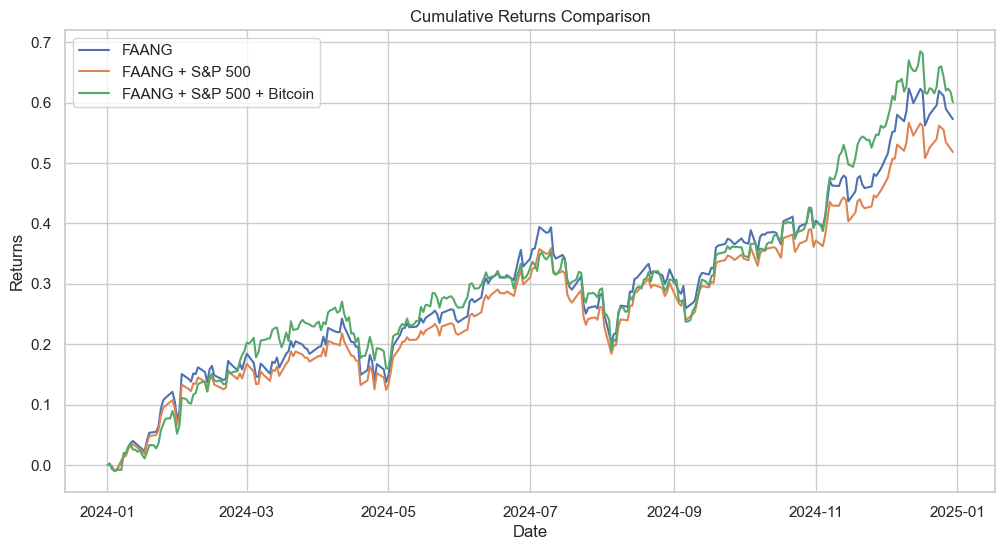

C:\Users\alanm\AppData\Local\Temp\ipykernel_16616\1568513543.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data[f'{window}D_MA'] = stock_data.rolling(window=window).mean()


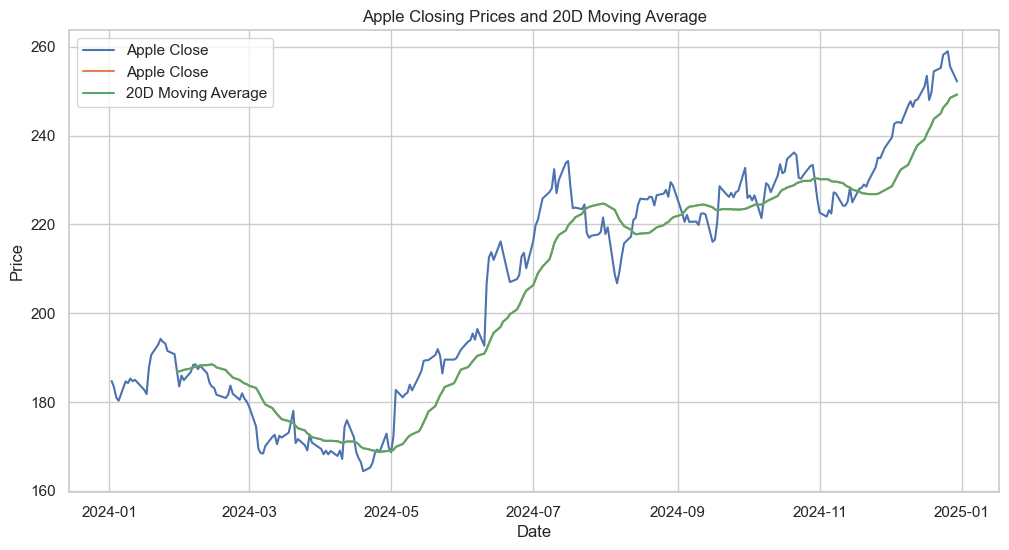

In [100]:
# Define the date range for fetching data
start_date = '2024-01-01'
end_date = '2024-12-31'

# Fetch data using yfinance
def fetch_stock_data(ticker):
    """
    Fetches historical stock data for a given ticker symbol using yfinance.
    Returns a DataFrame with the fetched data.
    """
    return download(ticker, start=start_date, end=end_date)

# Get FAANG and market data
fb_data = fetch_stock_data('META') 
aapl_data = fetch_stock_data('AAPL')
amzn_data = fetch_stock_data('AMZN') 
nflx_data = fetch_stock_data('NFLX')
goog_data = fetch_stock_data('GOOG')
sp500_data = fetch_stock_data('^GSPC') 
bitcoin_data = fetch_stock_data('BTC-USD')

# Group stocks into DataFrames
def group_stocks(stock_dict):
    """
    Groups stock data from a dictionary into a single DataFrame.
    The resulting DataFrame has stock tickers as column names and closing prices as values.
    """
    return pd.concat({key: stock['Close'] for key, stock in stock_dict.items()}, axis=1)

faang_data = group_stocks({
    'Facebook': fb_data,
    'Apple': aapl_data, 
    'Amazon': amzn_data,
    'Netflix': nflx_data,
    'Google': goog_data
})

faang_sp500_data = group_stocks({
    'Facebook': fb_data,
    'Apple': aapl_data,
    'Amazon': amzn_data,
    'Netflix': nflx_data,
    'Google': goog_data,
    'S&P 500': sp500_data
})

all_assets_data = group_stocks({
    'Facebook': fb_data,
    'Apple': aapl_data,
    'Amazon': amzn_data,
    'Netflix': nflx_data,
    'Google': goog_data, 
    'S&P 500': sp500_data,
    'Bitcoin': bitcoin_data
})

# Functions for calculating returns
def calculate_returns(data):
    """Calculates daily returns."""
    return data.pct_change().fillna(0)

def calculate_cumulative_returns(data):
    """Calculates cumulative returns."""
    returns = calculate_returns(data)
    return (1 + returns).cumprod() - 1

# Plotting
def plot_cumulative_returns(data):
    """Plots cumulative returns for the given data."""
    cumulative_returns = calculate_cumulative_returns(data)
    
    plt.figure(figsize=(12, 6))
    for col in cumulative_returns.columns:
        plt.plot(cumulative_returns[col], label=col)
    
    plt.title("Cumulative Returns")
    plt.xlabel("Date") 
    plt.ylabel("Returns")
    plt.legend()
    plt.show()

def plot_grouped_cumulative_returns(*datasets, labels):
    """Plots cumulative returns for grouped datasets."""
    plt.figure(figsize=(12, 6))
    for data, label in zip(datasets, labels):
        cumulative_returns = calculate_cumulative_returns(data).mean(axis=1)
        plt.plot(cumulative_returns, label=label)
    
    plt.title("Cumulative Returns Comparison")
    plt.xlabel("Date")
    plt.ylabel("Returns")
    plt.legend()
    plt.show()

def plot_moving_averages(data, ticker, window=20):
    """Plots closing prices and moving average for a given stock ticker."""
    stock_data = data[ticker]
    stock_data[f'{window}D_MA'] = stock_data.rolling(window=window).mean()
    
    plt.figure(figsize=(12, 6))
    plt.plot(stock_data, label=f'{ticker} Close')
    plt.plot(stock_data[f'{window}D_MA'], label=f'{window}D Moving Average')
    plt.title(f"{ticker} Closing Prices and {window}D Moving Average")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

# Example usage
plot_cumulative_returns(all_assets_data)

# Compare cumulative returns across groups
plot_grouped_cumulative_returns(faang_data, faang_sp500_data, all_assets_data, 
                                 labels=["FAANG", "FAANG + S&P 500", "FAANG + S&P 500 + Bitcoin"])

plot_moving_averages(faang_data, 'Apple')